In [8]:
#This notebook will be plotting SOM_4 ERA5 MSLP Figures and figures relating to just SOM_4

#This notebook is also plotting individual weather patterns in SOM 4 and checking if the mean image matches up

#Created: 8/02/22 by Taylor Dolan
#Last edit: 8/13/22

#Imports
import xarray as xr
import numpy as np
import pandas as pd
import warnings
from itertools import product
import matplotlib.pyplot as plt
import minisom
from minisom import asymptotic_decay
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle
import glob as glob
import os
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import Normalize
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
    The default options are retrieved by calling sammon(x) with no
    parameters.
    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot
    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].
    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.
    Copyright   : (c) Dr Gavin C. Cawley, November 2007.
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA
    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

def roll_climo(nparray, data, month, yrsroll=30, centered=True):
    """
    Creating rolling 30-year mean climatology.

    Args:
        data (xarray dataarray): Data Array weighted mean already computed.
        month (int): Month for climatology.
        yrsroll (int): Number of years for climatology. Defaults to ``30``.
        centered (boolean): Whether the average is centered. Defaults to True.
        time (str): Time coordinate name. Defaults to ``time``.
    """
    nparray = nparray[data.time.dt.month == month, :, :]

    array = xr.DataArray(
        data=nparray,
        dims=["time", "lat", "lon"],
        coords=dict(
            lon=(["lon"], data.coords['lon'].values),
            lat=(["lat"], data.coords['lat'].values),
            time=(["time"], data.time[data.time.dt.month == month].values),
        )
    ).rolling(time=yrsroll, min_periods=1, center=centered).mean(skipna=True)

    return array

def monthly_climo(nparray, data, yrsroll=30, centered=True, time='time'):
    """
    Create rolling mean climatology.
    Performs what xr.DataArray.groupby('time.month').rolling() would do.

    Args:
        data (xarray data array): Weighted mean variable.
        yrsroll (int): Number of years for climatology. Defaults to ``30``.
        centered (boolean): Whether the average is centered. Defaults to ``True``.
        time (str): Time coordinate name. Defaults to ``time``.

    Returns:
        nino_climo with rolling mean computed along months.
    """
    with warnings.catch_warnings():

        # ignore computer performance warning here on chunks
        warnings.simplefilter("ignore")

        jan = roll_climo(nparray, data, month=1, yrsroll=30, centered=True)
        feb = roll_climo(nparray, data, month=2, yrsroll=30, centered=True)
        mar = roll_climo(nparray, data, month=3, yrsroll=30, centered=True)
        apr = roll_climo(nparray, data, month=4, yrsroll=30, centered=True)
        boo = roll_climo(nparray, data, month=10, yrsroll=30, centered=True)
        nov = roll_climo(nparray, data, month=11, yrsroll=30, centered=True)
        dec = roll_climo(nparray, data, month=12, yrsroll=30, centered=True)

        nino_climo = xr.concat([jan, feb, mar, apr, boo, nov, dec], dim=time).sortby(time)

    return nino_climo

def normalize_data(data):
    """
    Function for nromalizing data prior to training (using z-score)
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [9]:
#Load in the winning SOM (ERA5 MSLP SOM_4)
with open('/glade/work/tdolan/asymptotic_decay_soms_ERA5/test_4x6/4x4_lr_0.005_100k_iteration/som_4.p', 'rb') as infile:
    som_4 = pickle.load(infile)

In [10]:
#Open the ERA5 Dataset
PATH = '/glade/work/tdolan/era5_psl/'
dy = xr.open_dataset(PATH+'e5.MSLP_1979-2021.nc') #open the dataset

In [11]:
#Extracting the data only for the region of study.
min_lon = 241
min_lat = 35
max_lon = 278
max_lat = 60

mask_lon = (dy.lon >= min_lon) & (dy.lon <= max_lon)
mask_lat = (dy.lat >= min_lat) & (dy.lat <= max_lat)

da = dy.where(mask_lon & mask_lat, drop=True)

In [12]:
#We are now only grabbing the Winter months for the SOM code.
ds = da.isel(time=da.time.dt.month.isin([1,2,3,4,10,11,12]))

In [13]:
#Normalizing data in the following code blocks.
mslpraw = (ds['MSL'])/100
lon = ds['lon'].values
lat = ds['lat'].values
time_values = ds['time'].values

#generate the empty array
nday =int((ds['time'].size))
nx = int((ds['lat'].size))
ny = int((ds['lon'].size))
mslparr = np.empty((nday, nx*ny)) #mslp at each grid point

In [ ]:
#We are now going to place the raw MSLP data into the array (mslparr)
for i in range(nday):
    mslparr[i,:]= mslpraw[i,:,:].stack(point=["lat", "lon"])

In [ ]:
#We are now calculating the hourly anomaly data. The hourly mean will be removed from the data. 
for i in range(nday):
    mslparr[i,:] =mslparr[i,:]-np.mean(mslparr[i,:])

In [ ]:
#We are now going to be normalizing the data by finding the minimum and maximum and generating a factor to multiple to the data. The factor is based off the hourly
#max and min in the MSLP data
maxmslp=-9999999
minmslp=999999   #we are setting the minmslp and maxmslp variables to a value so that there is no junk in the variable and each will easily overcome the set value.

for i in range(nday):
    minmslp=min(minmslp,np.min(mslparr[i,:]))
    maxmslp=max(maxmslp,np.max(mslparr[i,:]))
#print(maxmslp, minmslp)

#We are generating the MSLP factor to be multipled to the data to normalize it
mslp_factor=100./(maxmslp-minmslp)
#print(mslp_factor)

#The data is now being normalized.
data_train = mslparr*mslp_factor

In [ ]:
list = np.arange(0,data_train.shape[0],2)
newdata= data_train[list, :] #grabbing every 6 hours
#newdata.shape

In [14]:
#Calculate the MSLP Anomalies
ds01 = xr.open_dataset(PATH+'e5.MSLP_1979-2021.nc')

#Extracting the data only for the region of study.
min_lon = 241
min_lat = 35
max_lon = 278
max_lat = 60

mask_lon = (ds01.lon >= min_lon) & (ds01.lon <= max_lon)
mask_lat = (ds01.lat >= min_lat) & (ds01.lat <= max_lat)

da = ds01.where(mask_lon & mask_lat, drop=True)

ds = da.isel(time=da.time.dt.month.isin([1,2,3,4,10,11,12]))

# load data eagerly
thedata = ds['MSL'].values

# Calculate the climatology
climo_01 = monthly_climo(thedata, ds['MSL'], yrsroll=30, centered=True, time='time')/100

# Calculate the anomaly
anom_01 = ds['MSL']/100 - climo_01 #Use this to plot the anomalies

In [55]:
anom_01

<xarray.DataArray (time: 73488, lat: 27, lon: 30)>
array([[[-5.25454541e+00, -1.04522028e+01, -1.09496938e+01, ...,
          3.68683464e+00,  6.33511882e+00,  8.76155534e+00],
        [-2.93032715e+00, -1.24209355e+01, -1.25687451e+01, ...,
          1.32920117e+00,  4.46976937e+00,  6.18284619e+00],
        [-6.15751416e+00, -1.30507806e+01, -1.52339930e+01, ...,
         -4.72271484e-01,  1.95977734e+00,  4.61859473e+00],
        ...,
        [ 3.49299219e+00,  3.30069434e+00,  3.77897461e+00, ...,
          6.71953743e+00,  6.89652474e+00,  7.05837402e+00],
        [ 3.43796061e+00,  3.74957943e+00,  2.71650651e+00, ...,
          5.25301530e+00,  5.57620833e+00,  5.82706950e+00],
        [ 2.93637305e+00,  3.61579362e+00,  3.65508952e+00, ...,
          3.71171452e+00,  4.04876807e+00,  4.35723014e+00]],

       [[-3.41215820e+00, -9.78391113e+00, -1.02742944e+01, ...,
          2.20693604e+00,  4.99906250e+00,  7.90268066e+00],
        [-2.50606445e+00, -1.10108765e+01, -1.13354419e+01, ...,
         -6.39941406e-02,  3.35155029e+00,  4.61813477e+00],
        [-6.72344727e+00, -1.23103979e+01, -1.28375684e+01, ...,
         -1.40413330e+00,  1.10484863e+00,  3.29918945e+00],
...
        [-1.32299316e+00, -1.60612721e+00, -2.14012379e+00, ...,
          2.44332046e+00,  3.33716352e+00,  4.23361702e+00],
        [-1.98811667e+00, -2.23132683e+00, -2.55861673e+00, ...,
          1.98753777e+00,  2.93067771e+00,  3.90070959e+00],
        [-2.68536664e+00, -2.99043874e+00, -2.85900506e+00, ...,
          1.71916016e+00,  2.67431842e+00,  3.63530360e+00]],

       [[-3.93142822e+00, -4.79960449e+00, -5.07320312e+00, ...,
         -3.65424561e+00, -3.69935547e+00, -3.51616943e+00],
        [-3.05078857e+00, -4.21740479e+00, -4.94979492e+00, ...,
         -4.11986328e+00, -3.97513184e+00, -3.98131836e+00],
        [-2.25549805e+00, -3.84229492e+00, -4.52891357e+00, ...,
         -3.80686523e+00, -4.22978027e+00, -4.49383057e+00],
        ...,
        [-3.25421387e+00, -2.86854492e+00, -3.21648437e+00, ...,
          1.42131348e+00,  2.60938721e+00,  3.77336914e+00],
        [-3.03979492e+00, -3.30020752e+00, -3.42123047e+00, ...,
          1.46092529e+00,  2.59615723e+00,  3.71002930e+00],
        [-4.00679443e+00, -4.42521240e+00, -3.84442383e+00, ...,
          1.48736084e+00,  2.59384277e+00,  3.64455322e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2022-02-28T21:00:00
  * lon      (lon) float64 241.2 242.5 243.8 245.0 ... 273.8 275.0 276.2 277.5
  * lat      (lat) float64 35.34 36.28 37.23 38.17 ... 57.02 57.96 58.9 59.84

In [15]:
#Export data_train to an nc file
#dt = xr.DataArray(data_train)
#dt.to_netcdf('data_train_era5_mslp.nc')

In [16]:
#Import data_train_era5_mslp
PATH_ERA5 = '/glade/work/tdolan/'
dt = xr.open_dataset(PATH_ERA5+'data_train_era5_mslp.nc')
dt['ERA5_MSLP'] = dt['__xarray_dataarray_variable__'] #change the variable name for easy access
dt = dt.drop(['__xarray_dataarray_variable__'])

data = dt['ERA5_MSLP']
test = np.array(data) #This is the values from data_train_cesm as an array (needed to match up times)

In [17]:
#Create a dictionary for the rows and columns of the SOM for CESM
keys_era5 = [i for i in product(range(4), range(4))]
winmap_era5 = {key: [] for key in keys_era5}

In [18]:
#Create a function to print out the era5 keys to a list
def getList(dict):
    list = []
    for key in winmap_era5.keys():
        list.append(key)
         
    return list

In [19]:
#Load in the winning SOM and match up the times to ERA5
for i, x in enumerate(test):
    winmap_era5[som_4.winner(x)].append(i)
    
som_keys_era5 = getList(winmap_era5)
frequencies_era5 = som_4.activation_response(test)

In [ ]:
#Plot the distance map for SOM4

In [ ]:
#Plot the distance map for SOM4
plt.figure(figsize=(6,6))
cs = plt.pcolormesh(som_4.distance_map(), cmap='bone_r')
plt.title('distance map of the weights', fontsize=12)
plt.colorbar(cs)
plt.ylim(4, 0) # flip y axis to be the same as the composite map axes later
plt.show()

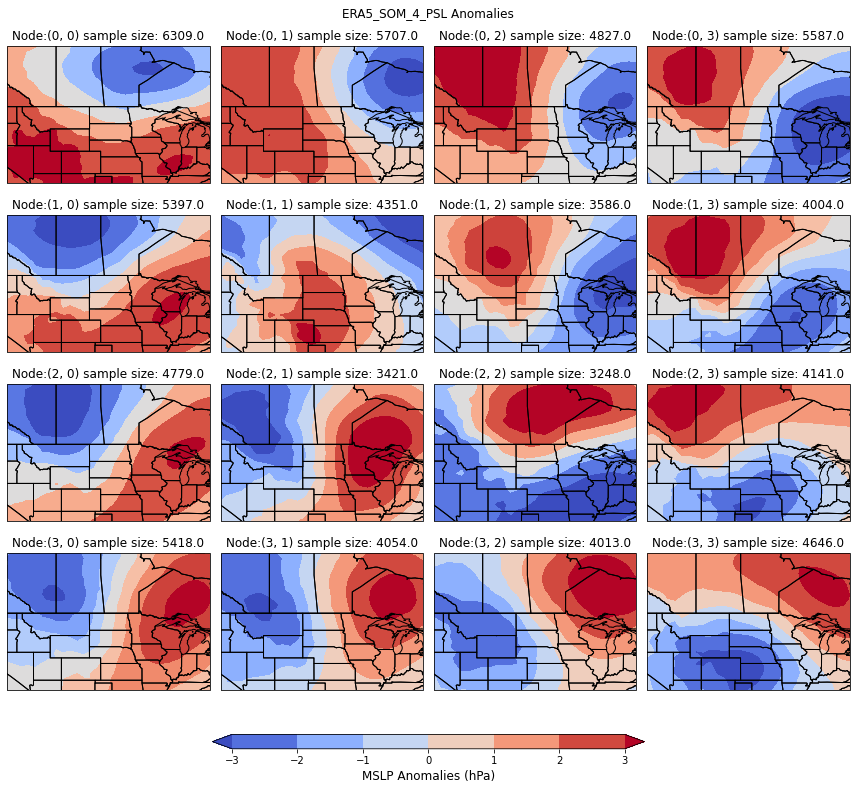

In [49]:
#Plot ERA5 SOM_4 MSLP anomalies using Maria's method

fig, axs = plt.subplots(4, 4, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,10)) #width,height

for map_num in range(len(som_keys_era5)):
    temp_data = anom_01[np.array(winmap_era5[som_keys_era5[map_num]]),:,:].mean(['time'])
    node = som_keys_era5[map_num]
    cs2 = axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].contourf(lon, lat, temp_data, cmap='coolwarm',extend='both', transform=ccrs.PlateCarree())
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].set_title('Node:' + str(node) + ' ' + f"sample size: {frequencies_era5.flatten()[map_num]}", fontsize=12)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].coastlines()
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.STATES)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.BORDERS)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar=fig.colorbar(cs2,cax=cbar_ax,orientation='horizontal')
cbar.set_label('MSLP Anomalies (hPa)', fontsize=12)

plt.suptitle('ERA5_SOM_4_PSL Anomalies', fontsize = 12)

plt.tight_layout()
#plt.savefig('ERA5_SOM_4_PSL_ANOMS.png')
plt.show()

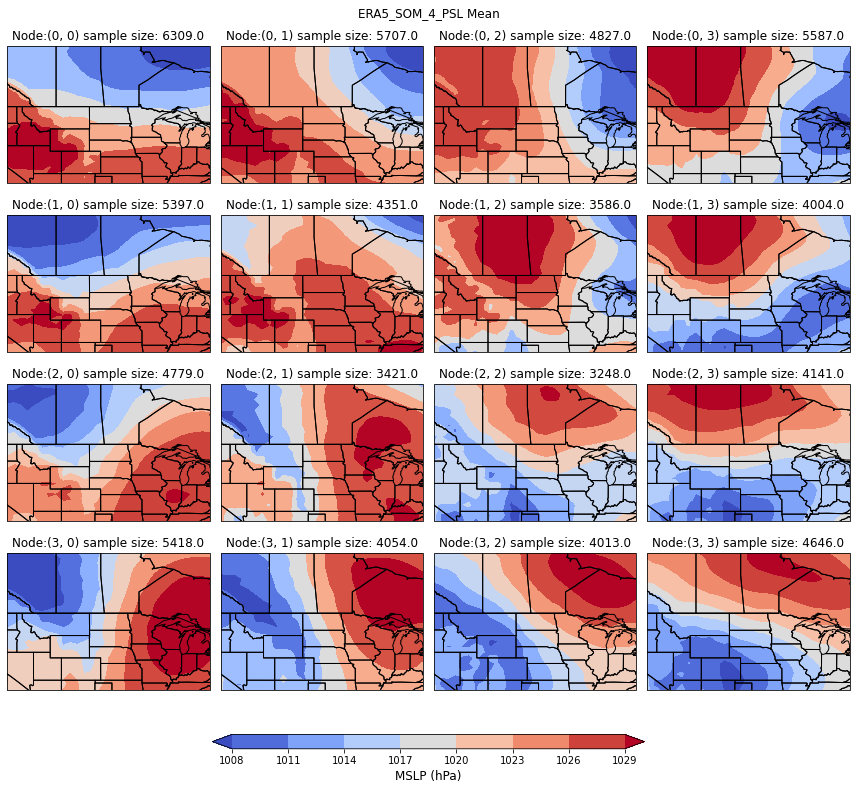

In [21]:
#Plot ERA5 SOm_4 MSLP Mean Values
fig, axs = plt.subplots(4, 4, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,10)) #width,height

for map_num in range(len(som_keys_era5)):
    temp_data = mslpraw[np.array(winmap_era5[som_keys_era5[map_num]]),:,:].mean(['time'])
    node = som_keys_era5[map_num]
    cs2 = axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].contourf(lon, lat, temp_data, cmap='coolwarm',extend='both', transform=ccrs.PlateCarree())
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].set_title('Node:' + str(node) + ' ' + f"sample size: {frequencies_era5.flatten()[map_num]}", fontsize=12)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].coastlines()
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.STATES)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.BORDERS)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar=fig.colorbar(cs2,cax=cbar_ax,orientation='horizontal')
cbar.set_label('MSLP (hPa)', fontsize=12)

plt.suptitle('ERA5_SOM_4_PSL Mean', fontsize = 12)

plt.tight_layout()
#plt.savefig('ERA5_SOM_4_PSL_Means.png')
plt.show()

In [22]:
#Load the times in node (0,0)
node_0_0 = (pd.to_datetime(time_values[(winmap_era5[(0,0)])])).strftime("%Y-%m-%d-%H").tolist()

#Load the times in node (0,3)
node_0_3 = (pd.to_datetime(time_values[(winmap_era5[(0,3)])])).strftime("%Y-%m-%d-%H").tolist()  #1987, Jan 15th

#Load the times in node (2,2)
node_2_2 = (pd.to_datetime(time_values[(winmap_era5[(2,2)])])).strftime("%Y-%m-%d-%H").tolist() #1991, Feb 17th

In [43]:
node_2_2[1001]

'1991-02-18-00'

In [44]:
#Time indices of node (0,0)
times_node0 = winmap_era5[(0,0)]

#Time indicies of node (0,3)
times_node_03 = winmap_era5[(0,3)]

#Time indicies of node (2,2)
times_node_2_2 = winmap_era5[(2,2)]

#Pick one time (1979, January 5th)
jan_time = winmap_era5[(0,0)][0:4]

#Pick one time (1987, January 15th)
jan_87 = winmap_era5[(0,3)][999:1002]

#Pick one time (1991, Feb 17th)
feb_91 = winmap_era5[(2,2)][996:1000]

In [52]:
#Values of MSL (normal) based on the time indices in node 0,0
mslp_node0 = mslpraw[times_node0]
anoms_mslp_node0 = anom_01[times_node0]

#Values of MSL (normal) based on the time indices in node 0,3
mslp_node_03 = mslpraw[times_node_03]
anoms_mslp_node03 = anom_01[times_node_03]

jan_mslp = mslpraw[jan_time]
jan_87_mslp = mslpraw[jan_87]

#MSLP values in node (2,2)
mslp_node_2_2 = mslpraw[times_node_2_2]
anoms_mslp_node_2_2 = anom_01[times_node_2_2]
feb_91_mslp = mslpraw[feb_91]

#Mean MSLP in node 0,0
mean_mslp = mslp_node0.mean(['time'])
jan_mean = jan_mslp.mean(['time'])

#Mean MSLP in node 0,3
mean_mslp_03 = mslp_node_03.mean(['time'])
jan_87_mean = jan_87_mslp.mean(['time'])

#Mean MSLP in node (2,2)
mean_mslp_node_2_2 = mslp_node_2_2.mean(['time'])
feb_91_mean = feb_91_mslp.mean(['time'])

#Mean of the anomalies of MSLP in node (0,0)
mean_anom_mslp = anoms_mslp_node0.mean(['time'])

#Mean of the anomalies of MSLP in node (0,3)
mean_anom_mslp_03 = anoms_mslp_node03.mean(['time'])

#Mean of the anomalies of MSLP in node (2,2)
mean_anom_mslp_2_2 = anoms_mslp_node_2_2.mean(['time'])

In [ ]:
#Plot the mean mslp of node (0,0) and mean of the anomalies

In [ ]:
#Plot the mean mslp of node (0,0) and mean of the anomalies
ax = plt.axes(projection=ccrs.PlateCarree())
#cont = plt.contourf(lon, lat, mean_anom_mslp, cmap='coolwarm')
cont = plt.contourf(lon, lat, mean_mslp, cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
#cbar_ax = ax.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar= plt.colorbar(cont,orientation='horizontal')
cbar.set_label('MSLP (hPa)', fontsize=12)
plt.tight_layout()
plt.title('Node (0,0) MSLP')
plt.show()

In [ ]:
#Plot the mean mslp of node (0,3) and mean of the anomalies

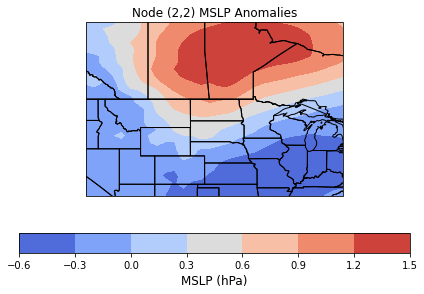

In [30]:
#Plot the mean mslp of node (0,3) and mean of the anomalies
ax = plt.axes(projection=ccrs.PlateCarree())
cont = plt.contourf(lon, lat, mean_anom_mslp_2_2, cmap='coolwarm')
#cont = plt.contourf(lon, lat, mean_mslp_03, cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
#cbar_ax = ax.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar= plt.colorbar(cont,orientation='horizontal')
cbar.set_label('MSLP (hPa)', fontsize=12)
plt.tight_layout()
plt.title('Node (2,2) MSLP Anomalies')
plt.show()

In [ ]:
#Plot the mean mslp of node (2,2) and mean of the anomalies

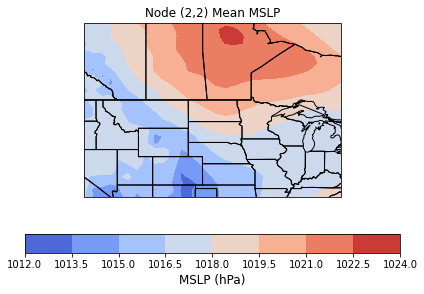

In [27]:
#Plot the mean mslp of node (2,2) and mean of the anomalies
ax = plt.axes(projection=ccrs.PlateCarree())
#cont = plt.contourf(lon, lat, mean_anom_mslp_03, cmap='coolwarm')
cont = plt.contourf(lon, lat, mean_mslp_node_2_2, cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
#cbar_ax = ax.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar= plt.colorbar(cont,orientation='horizontal')
cbar.set_label('MSLP (hPa)', fontsize=12)
plt.tight_layout()
plt.title('Node (2,2) Mean MSLP')
plt.show()

In [ ]:
#Plot just 1979 January 5th from node (0,0) and see if it looks like the mean image

In [ ]:
#Plot just 1979 January 5th from node (0,0) and see if it looks like the mean image
ax = plt.axes(projection=ccrs.PlateCarree())
cont = plt.contourf(lon, lat, jan_mean, cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
#cbar_ax = ax.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar= plt.colorbar(cont,orientation='horizontal')
cbar.set_label('MSLP (hPa)', fontsize=12)
plt.tight_layout()
plt.title('Node (0,0) Jan 5th 1979 MSLP')
#plt.savefig('Node0_0_jan1979_mean_mslp')
plt.show()

In [ ]:
#Plot just 1987, January 15th from node (0,3)

In [ ]:
#Plot just 1987, January 15th from node (0,3)
ax = plt.axes(projection=ccrs.PlateCarree())
cont = plt.contourf(lon, lat, jan_87_mean, cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
cbar= plt.colorbar(cont,orientation='horizontal')
cbar.set_label('MSLP (hPa)', fontsize=12)
plt.tight_layout()
plt.title('Node (0,3) Jan 15th 1987 MSLP')
plt.show()

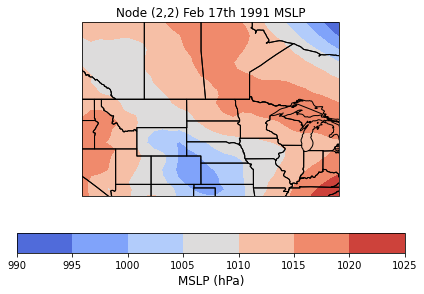

In [54]:
#Plot just 1991, Feb 17th from node (2,2)
ax = plt.axes(projection=ccrs.PlateCarree())
cont = plt.contourf(lon, lat, feb_91_mean, cmap='coolwarm')
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
cbar= plt.colorbar(cont,orientation='horizontal')
cbar.set_label('MSLP (hPa)', fontsize=12)
plt.tight_layout()
plt.title('Node (2,2) Feb 17th 1991 MSLP')
plt.show()

In [ ]:
#Plot SOM_4 MSLP Anomalies over the study region
#This is using Talia's method

In [ ]:
#Plot SOM_4 MSLP Anomalies over the study region
#This is using Talia's method

with open('/glade/work/tdolan/asymptotic_decay_soms_ERA5/test_4x6/4x4_lr_0.005_100k_iteration/som_4.p', 'rb') as infile:
    som_4 = pickle.load(infile)
    frequencies = som_4.activation_response(data_train)
    som_weights= som_4._weights
    nrows = som_weights.shape[0]
    ncols = som_weights.shape[1]

    fig, axs = plt.subplots(4, 4, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(20,11))
    fig.tight_layout()
    axs=axs.flatten()
  
    for i in range(som_weights.shape[0]):
        for k in range(som_weights.shape[1]):
            mslp = som_weights[i,k,:].reshape(nx,ny)
            node=(i+1)+k*som_weights.shape[0]
            cs2=axs[i+k*som_weights.shape[0]].contourf(lon, lat, mslp,
                    transform = ccrs.PlateCarree(),
                    cmap='coolwarm',extend='both')
            axs[i+k*som_weights.shape[0]].coastlines()
            axs[i+k*som_weights.shape[0]].add_feature(cfeature.BORDERS) 
            axs[i+k*som_weights.shape[0]].add_feature(cfeature.STATES)

        # Title each subplot 
            axs[i+k*som_weights.shape[0]].set_title('Node' + ' ' +str(node) + ',' + ' ' + f"Sample Size: {frequencies.flatten()[i+k*som_weights.shape[0]]}", fontsize=12)
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.6,
            wspace=0.05, hspace=0.25)


# Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.08, 0.2, 0.5, 0.02])

    cbar=fig.colorbar(cs2,cax=cbar_ax,orientation='horizontal')

    cbar.set_label('MSLP Anomalies (hPa)', fontsize=13)

# Add a big title at the top
    plt.suptitle('SOM_4 MSLP Anomalies', x= 0.33 ,fontsize=13)
    #plt.savefig('SOM_4_Anoms_Sample_Size.png')
    plt.show()

In [ ]:
#Plot the frequency distribution of SOM_4 and the Sammon Map

In [ ]:
#Plot the frequency distribution of SOM_4 and the Sammon Map
som_col = 4
som_row = 4
x_coor =4
y_coor= 4

input_length = 810
mslp = mslpraw.values

with open('/glade/work/tdolan/asymptotic_decay_soms_ERA5/test_4x6/4x4_lr_0.005_100k_iteration/som_4.p', 'rb') as infile:
        som_4 = pickle.load(infile) #This is loading every single som in that location
        frequencies = som_4.activation_response(newdata) #this is grabbing each freq
        q_error = round(som_4.quantization_error(newdata),4) #this is grabbing every q error out to 4 decimal places
        topo_error = round(som_4.topographic_error(newdata),4) #this is grabbing ever topographic error out to 4 decimal places
        plt.figure(figsize=(6,6))
        cs = plt.pcolormesh(frequencies, cmap='Blues')
        plt.title('SOM_4 Frequencies',fontsize=12)
        plt.colorbar(cs)
        plt.ylim(4, 0) # Change the 4 to whatever size SOM you have (this is the 2nd number)
        plt.tight_layout()
        #plt.savefig(folderpath + 'frequencies_'+name+'.png') #I am saving the outputs as a png file in the same file path and giving it the name of each SOM
        plt.show()
        
        [y,E] = sammon(som_4.get_weights().reshape(som_col*som_row, input_length),2,display=1)

            # Plot Sammon map nodes
        plt.figure(figsize=(10,8))
        plt.scatter(y[:,0], y[:,1], s=20, c='black', marker='o')

            # Add lines between nodes
        mslp = np.reshape(y,(som_row,som_col,2))
        len_x, len_y, len_z = mslp.shape

        # add vertical lines
        for i in range(len_x-1):
            for j in range(len_y):
                plt.plot(mslp[i:i+2,j,0],mslp[i:i+2,j,1],c='black')

        # add horizontal lines
        for i in range(len_x):
            for j in range(len_y-1):
                plt.plot(mslp[i,j:j+2,0],mslp[i,j:j+2,1],c='black')  

        plt.xticks([])
        plt.yticks([])
        plt.title('SOM_4', fontsize=12)
        #plt.savefig(folderpath + 'sammonplot_'+name+'.png') #I am saving the outputs as a png file in the same file path and giving it the name of each SOM
        plt.show()
